# Earnings effect -- Bayesian Version

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

In [ ]:
from pathlib import Path
from dataclasses import dataclass, fields
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpyro as pyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random

from scipy.stats import norm, mstats
from estimators import BayesianRidgeStat
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, balanced_accuracy_score, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.base import BaseEstimator
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel, Sum

from lightgbm import LGBMClassifier
from xbcausalforest import XBCF

from reed import drop_missing_treatment_or_outcome, Model, transform_outcome
from direct_regression import seperate_and_transform_data, print_unconditional_effects

%matplotlib inline

## Analysis Parameters

In [2]:
log_outcome=False
standardize_outcome=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

#configuration_name = 'default'
outcome = 'y_wscei'
treatment = 'redufl'
test = False
data_file = Path("~/code/re-education/data/all_lasso_selected_100_restricted.csv")

## Load the data

Dropped 0 rows missing treatment or outcome.


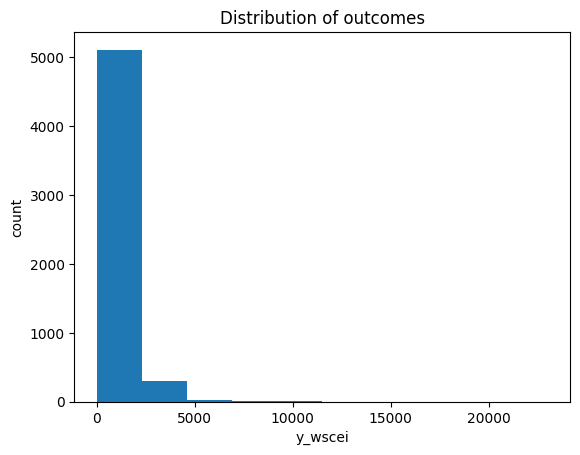

In [3]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

## Prepare data for modeling

- split into treated/control
- impute missing values and scale
- separate features from outcomes&treatments



In [4]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ", X0.shape)
print("Treated data dimensions:", X1.shape)

Control data dimensions:  (4043, 91)
Treated data dimensions: (1398, 91)


## Compute unconditional/unadjusted estimate of treatment effect

In [5]:
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:529.34±16.41
Average outcome under Treatment:860.37±27.84
Unadjusted treatment estimate 331.03


## Statsmodels

### OLS S-learner

In [6]:
Xt = np.hstack((t[:, np.newaxis], X))
Xt = pd.DataFrame(data=Xt, columns=["treatment"] + features)
ols = sm.OLS(y, sm.add_constant(Xt))
res = ols.fit()
ate_ols = res.params.loc["treatment"]
ci_ols = res.conf_int().loc["treatment"]
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     30.30
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:27:37   Log-Likelihood:                -44444.
No. Observations:                5441   AIC:                         8.907e+04
Df Residuals:                    5348   BIC:                         8.969e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        598.3285     13.789     43.391      0.0

## Train a propensity score model

This should help with bias in estimating treatment effects with Bayesian models.

See:

[Hahn, P.R., Murray, J.S. and Carvalho, C.M., 2020. Bayesian regression tree models for causal inference: Regularization, confounding, and heterogeneous effects (with discussion). Bayesian Analysis, 15(3), pp.965-1056.](https://projecteuclid.org/journals/bayesian-analysis/volume-15/issue-3/Bayesian-Regression-Tree-Models-for-Causal-Inference--Regularization-Confounding/10.1214/19-BA1195.pdf)


For more information.

In [7]:
linear_prop = LogisticRegressionCV(max_iter=500)
nonlin_prop = GridSearchCV(
    LGBMClassifier(),
    param_grid={"learning_rate": [1e-3, 1e-2, 5e-2, 0.1, 0.5]},
    scoring="neg_log_loss",
    n_jobs=-1
)


@dataclass
class ScoreMap:
    sfn: callable
    sres: list
        
    def __init__(self, sfn):
        self.sfn = sfn
        self.sres = []

        
@dataclass
class Scores:
    accuracy: ScoreMap
    baccuracy: ScoreMap
    logloss: ScoreMap
    
    def __init__(self):
        self.accuracy = ScoreMap(sfn=accuracy_score)
        self.baccuracy = ScoreMap(sfn=balanced_accuracy_score)
        self.logloss = ScoreMap(sfn=log_loss)

        
@dataclass
class ModelMap:
    model: BaseEstimator
    propensity: np.ndarray
    scores: Scores
    
    def __init__(self, model):
        self.model = model
        self.propensity = np.zeros(len(t))  # zeros_like becomes immutable?
        self.scores = Scores()
        
    def set_ps(self, ind, p):
        self.propensity[ind] = p
        

pmodels = {
    "logistic": ModelMap(model=linear_prop),
    "gbc": ModelMap(model=nonlin_prop)
}

In [8]:
for i, (tr_ind, ts_ind) in enumerate(StratifiedKFold(n_splits=5, shuffle=True).split(X, t)):
    t_tr, t_ts = t[tr_ind], t[ts_ind]
    X_tr, X_ts = X[tr_ind], X[ts_ind]
    
    print(f"Round {i}")
    for name, props in pmodels.items():
        props.model.fit(X_tr, t_tr)
        p = props.model.predict_proba(X_ts)[:, 1]
        t_hat = (p > 0.5).astype(int)
        
        props.scores.logloss.sres.append(props.scores.logloss.sfn(t_ts, p))
        props.scores.baccuracy.sres.append(props.scores.baccuracy.sfn(t_ts, t_hat))
        props.scores.accuracy.sres.append(props.scores.accuracy.sfn(t_ts, t_hat))
        
        props.set_ps(ts_ind, p)

Round 0
Round 1
Round 2
Round 3
Round 4


In [9]:
for name, props in pmodels.items():
    for f in fields(props.scores):
        score = getattr(props.scores, f.name)
        smean, sstd = np.mean(score.sres), np.std(score.sres, ddof=1)
        print(f"{name}-{f.name}: {smean:.4f} ({sstd:.4f})")

logistic-accuracy: 0.7432 (0.0018)
logistic-baccuracy: 0.5032 (0.0037)
logistic-logloss: 0.5191 (0.0043)
gbc-accuracy: 0.7436 (0.0050)
gbc-baccuracy: 0.5392 (0.0195)
gbc-logloss: 0.5180 (0.0076)


In [10]:
# There is not much difference in model performance, so go with logistic model for simplicity
p = linear_prop.fit(X, t).predict(X)
#p = pmodels["gbc"].propensity

# RBF Features
Xrbf = Nystroem(gamma=1 / (10 * X.var() * X.shape[1]), n_components=1000).fit_transform(X)
#Xrbf = RBFSampler(gamma="scale", n_components=500).fit_transform(X)

# Augment features with this score
Xt = np.hstack((t[:, np.newaxis], p[:, np.newaxis], Xrbf))

/home/dsteinberg/.cache/pypoetry/virtualenvs/re-education-v9RC6Oqx-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Scikit learn Bayesian Estimators

### Bayesian Ridge S-learner

Coefficient statistics

In [11]:
blr = BayesianRidgeStat()
blr.fit(Xt, y)

score = blr.score(Xt, y)  # WARNING: score on training data!

# Coefficient statistics
stats = blr.model_statistics()
ate_blr, se_blr = stats.beta[0], stats.std_err[0]
ci_blr = norm.interval(loc=ate_blr, scale=se_blr, confidence=0.95)

print("Bayesian Ridge simple model - coefficient stats:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_blr:.4f} ({se_blr:.4f})")
print(f"  t: {stats.t_stat[0]:.4f}")
print(f"  p-value: {stats.p_value[0]:.4f}")
print(f"  CI (0.025, 0.975): [{ci_blr[0]:.4f}, {ci_blr[1]:.4f}]")

Bayesian Ridge simple model - coefficient stats:
  R-squared = 0.4463
  ATE: 70.0949 (27.4676)
  t: 2.5519
  p-value: 0.0107
  CI (0.025, 0.975): [16.2594, 123.9304]


## Gaussian Process

This Gaussian process implements the recommended model from (Hahn, 2020) above,
$$
    f(x_i, \pi_i, t_i) = \mu(x_i, \pi_i) + \tau(x_i)\cdot t_i
$$
as a GP with the composite kernel,
$$
    k_{\!f}([x_i, \pi_i, t_i], [x_j, \pi_j, t_j]) 
        = k_\mu([x_i, \pi_i], [x_j, \pi_j])
        + k_\tau(x_i, x_j) \cdot t_i t_j
$$

In [12]:
# Function to apply a kernel to a subset of dimensions:

def kernel_dimensions(KernelClass, Xdims):
    
    class KernelDims(KernelClass):
        
        def __call__(self, X, Y=None, eval_gradient=False):
            Xd = X[:, Xdims]
            Yd = Y
            if Y is not None:
                Yd = Y[:, Xdims]
            return super().__call__(Xd, Yd, eval_gradient)
        
        def diag(self, X):
            Xd = X[:, Xdims]
            return super().diag(Xd)
        
    return KernelDims

In [13]:
kernel = 1.0 * kernel_dimensions(Matern, slice(1, None))(length_scale=10., nu=1.5, length_scale_bounds=(1e-3, 1e3)) \
    + kernel_dimensions(DotProduct, [0])(sigma_0=0, sigma_0_bounds="fixed") \
    * (0.1 * kernel_dimensions(Matern, slice(2, None))(length_scale=50., nu=1.5, length_scale_bounds=(1e-3, 1e3)) + 1e-3) \
    + WhiteKernel()

gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

# This takes a while for 5000 samples...
Xg = np.hstack((t[:, np.newaxis], p[:, np.newaxis], X))
gp.fit(Xg, y)
score = gp.score(Xg, y) # WARNING: Score on training data - this is likely to overfit

In [14]:
# ATE sampling
Xt0 = np.hstack((np.zeros_like(t)[:, np.newaxis], p[:, np.newaxis], X))
Xt1 = np.hstack((np.ones_like(t)[:, np.newaxis], p[:, np.newaxis], X))
f0, K0 = gp.predict(Xt0, return_cov=True)
f1, K1 = gp.predict(Xt1, return_cov=True)

samples = 100
y_0_samples = np.random.multivariate_normal(mean=f0, cov=K0, size=samples)
y_1_samples = np.random.multivariate_normal(mean=f1, cov=K1, size=samples)
ate_gp_samples = (y_1_samples - y_0_samples).mean(axis=1)

ate_gp = ate_gp_samples.mean()
se_gp = np.std(ate_gp_samples, ddof=1)
ci_gp = norm.interval(loc=ate_gp, scale=se_gp, confidence=0.95)

print(f"Gaussian Process {gp.kernel_}:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_gp:.4f} ({se_gp:.4f})")
print(f"  CI (0.025, 0.975): [{ci_gp[0]:.4f}, {ci_gp[1]:.4f}]")

Gaussian Process 1.42**2 * KernelDims(length_scale=16, nu=1.5) + KernelDims(sigma_0=0) * 0.0517**2 * KernelDims(length_scale=243, nu=1.5) + 0.0312**2 + WhiteKernel(noise_level=0.368):
  R-squared = 0.7595
  ATE: 61.0728 (24.7143)
  CI (0.025, 0.975): [12.6337, 109.5120]


Check if GP is overfitting

In [15]:
cv_scores = cross_validate(
    gp,
    Xg,
    y,
    cv=KFold(n_splits=5, shuffle=True),
    return_train_score=True, n_jobs=2
)
pd.DataFrame(cv_scores).describe()

,fit_time,score_time,test_score,train_score
count,5.000000,5.000000,5.000000,5.000000
mean,323.751716,1.346438,0.308588,0.791226
std,79.146721,0.268189,0.076854,0.039502
min,246.170834,0.961526,0.213647,0.733868
25%,266.447112,1.267141,0.252771,0.769865
50%,320.675761,1.381485,0.320883,0.801266
75%,336.928937,1.419706,0.348156,0.821313
max,448.535938,1.702331,0.407482,0.829817


## Hierarchical Bayesian Linear Model

This model takes the following form and prior settings,

$$
\begin{align}
    \{\lambda_0, \lambda_x\, \sigma\} &\sim \textrm{HalfCauchy}(25) \\
    \{\lambda_{\pi}, \lambda_t, \lambda_{tx}\} &\sim \textrm{Uniform}(0, 1000) \\
    w_0 &\sim \mathcal{N}(0, \lambda_0^2) \\
    w_\pi &\sim \mathcal{N}(0, \lambda_\pi^2) \\
    \mathbf{w}_x &\sim \mathcal{N}(0, \lambda_x^2 \mathbf{I}_d) \\
    w_t &\sim \mathcal{N}(0, \lambda_t^2) \\
    \mathbf{w}_{tx} &\sim \mathcal{N}(0, \lambda_{tx}^2 \mathbf{I}_d) \\
    y_i &\sim \mathcal{N}(\mu(\mathbf{x}_i, t_i, \pi_i), \sigma^2) \\
    \mu(\mathbf{x}_i, t_i, \pi_i) &= \rho(\mathbf{x}_i, \pi_i) + t_i \cdot \tau(\mathbf{x}_i)\\
    \tau(\mathbf{x}_i) &= (\mathbf{w}_{tx}^\top\mathbf{x}_i + w_t)\\
    \rho(\mathbf{x}_i, \pi_i) &= w_0 + w_\pi \pi_i + \mathbf{w}_x^\top\mathbf{x}_i\\
\end{align}
$$

This explicitly models and interaction term, and can automatically regularise this term. This effectively allows the model to interpolate between an S and T-learner.

For ideas about choice of prior, we should refer to:

- Gelman, A. (2006). Prior distributions for variance parameters in hierarchical models. Bayesian analysis, 1(3), 515-534.

### Set up the model

In [16]:
def predict(w_0, w_t, w_x, w_tx, w_p, x, t, p):
    f = prognostic(w_0, w_x, w_p, x, p) + t * ite(w_tx, w_t, x)
    return f


def prognostic(w_0, w_x, w_p, x, p):
    mu = w_0 + w_p * p + x @ w_x
    return mu


def ite(w_tx, w_t, x):
    tau = x @ w_tx + w_t
    return tau


def model_treatment_intersection(x, t, p, y):
    n, d = x.shape
        
    # Hyper Priors
    l_0 = pyro.sample("l_0", dist.Uniform(0, 100))
    l_x = pyro.sample("l_x", dist.Uniform(0, 100))
    l_p = pyro.sample("l_p", dist.Uniform(0, 100))
    l_t = pyro.sample("l_t", dist.Uniform(0, 1000))
    l_tx = pyro.sample("l_tx", dist.Uniform(0, 1000))
    
    # Priors
    sigma = pyro.sample("stddev", dist.HalfCauchy(scale=25))
    p_wp = dist.Normal(0, l_p**2)
    p_w0 = dist.Normal(0, l_0**2)
    p_wx = dist.Normal(np.zeros(d), l_x**2 * np.ones(d))
    p_wt = dist.Normal(0, l_t**2)
    p_twx = dist.Normal(np.zeros(d), l_tx**2 * np.ones(d))
    
    # Model weights
    w_p = pyro.sample("propensity", p_wp)
    w_0 = pyro.sample("intercept", p_w0)
    w_t = pyro.sample("treatment", p_wt)
    w_x = pyro.sample("confounders", p_wx)
    w_tx = pyro.sample("intersection", p_twx)
    
    # Likelihood
    f = predict(w_0, w_t, w_x, w_tx, w_p, x, t, p)
    
    with pyro.plate("data", n):
        likelihood = dist.Normal(f, sigma**2)
        y = pyro.sample("likelihood", likelihood, obs=y)

### Run MCMC inference to compute the posteriors

In [17]:
samples = 1000
warm_up = 30000

# Initialize No U-Turn Sampler
nuts_kernel = NUTS(model_treatment_intersection, max_tree_depth=5)
model_mcmc = MCMC(nuts_kernel, num_samples=samples, num_warmup=warm_up, num_chains=1)

# Run the sampler
rng_key = random.PRNGKey(0)
model_mcmc.run(rng_key, X, t, p, y)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|█████████| 31000/31000 [04:06<00:00, 125.79it/s, 31 steps of size 4.05e-02. acc. prob=0.86]


In [18]:
model_mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  confounders[0]    -23.49     12.60    -23.53    -45.69     -5.00     90.72      1.05
  confounders[1]      2.85     12.86      2.06    -15.29     27.18     63.35      1.00
  confounders[2]     -3.58     12.36     -2.29    -25.93     13.73     96.12      1.03
  confounders[3]    -15.24     11.93    -15.61    -31.96      3.88     59.07      1.03
  confounders[4]     -5.50     11.61     -6.61    -25.13     13.50    110.13      1.00
  confounders[5]     21.70     10.64     22.74      3.94     38.48    153.37      1.00
  confounders[6]     24.94     12.51     25.80      3.67     41.72     64.83      1.00
  confounders[7]     10.61     12.29     10.53     -7.43     30.71     41.78      1.00
  confounders[8]     16.43     12.94     15.21     -1.40     38.60     29.27      1.01
  confounders[9]     43.17     14.42     42.98     22.48     65.41     72.75      1.00
 confounders[10]      9.98     25.98     1

### Sample the ATE

In [19]:
hbr_samples = model_mcmc.get_samples()
w_0s = hbr_samples["intercept"]
w_ps = hbr_samples["propensity"]
w_ts = hbr_samples["treatment"]
w_xs = hbr_samples["confounders"]
w_txs = hbr_samples["intersection"]

ate_hlr_samples = np.zeros(samples)
score_samples = np.zeros(samples)
t0 = np.zeros_like(t)
t1 = np.ones_like(t)

for s in range(samples):
    f = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], X, t, p)
    ate_hlr_samples[s] = ite(w_txs[s], w_ts[s], X).mean()
    score_samples[s] = r2_score(y, f)

ate_hlr = ate_hlr_samples.mean()
ci_hlr = mstats.mquantiles(ate_hlr_samples, prob=[0.025, 0.975])

print("Hierarchical Linear Regression")
print(f"  R-squared = {score_samples.mean():.4f} ({score_samples.std():.4f})")
print(f"  ATE: {ate_hlr:.4f}")
print(f"  CI (0.025, 0.975): [{ci_hlr[0]:.4f}, {ci_hlr[1]:.4f}]")

Hierarchical Linear Regression
  R-squared = 0.3318 (0.0016)
  ATE: 63.2201
  CI (0.025, 0.975): [0.6292, 121.6997]


### Sample and display some posterior distributions

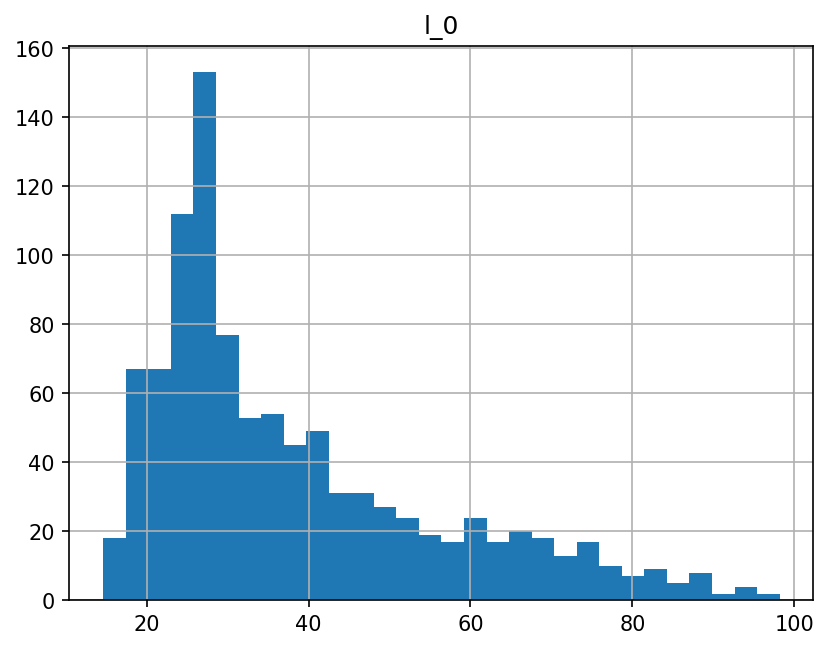

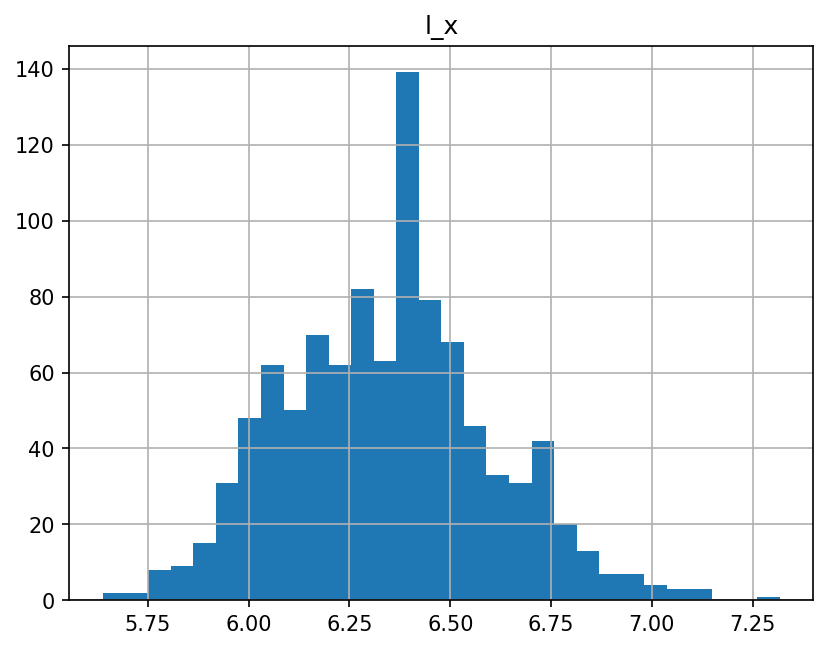

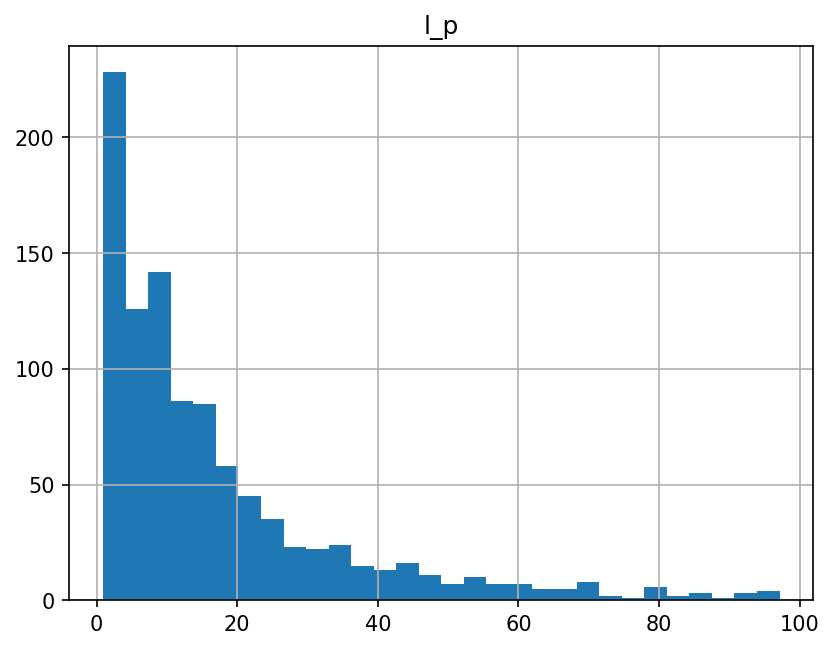

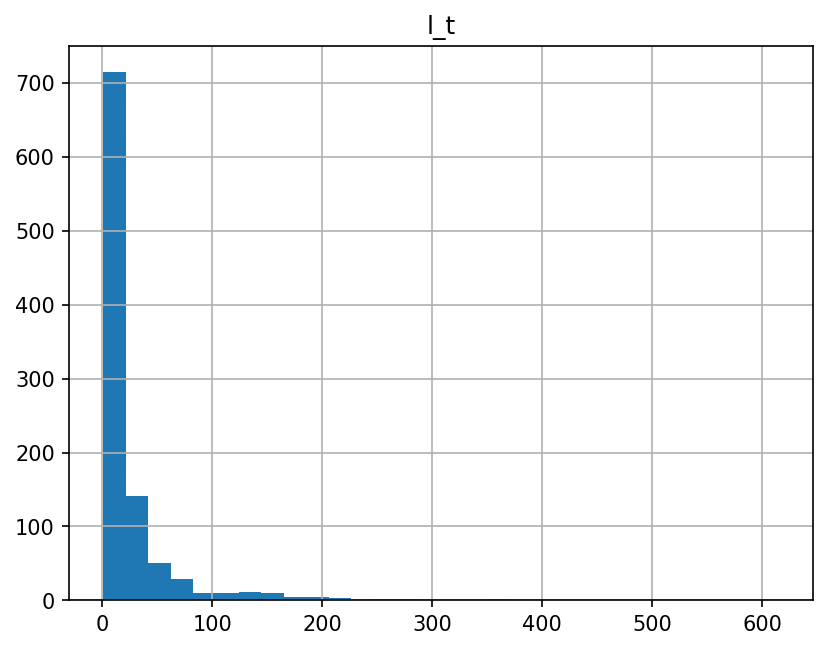

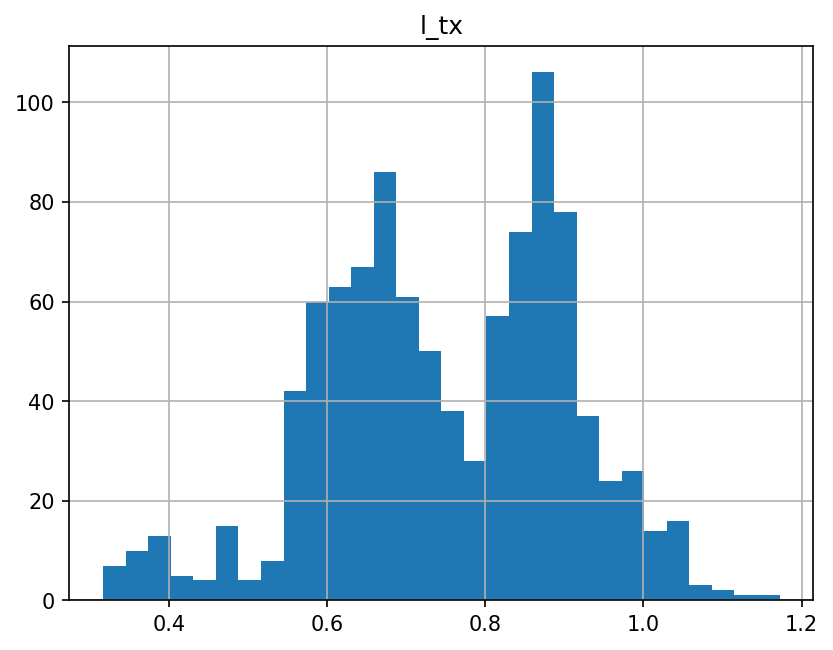

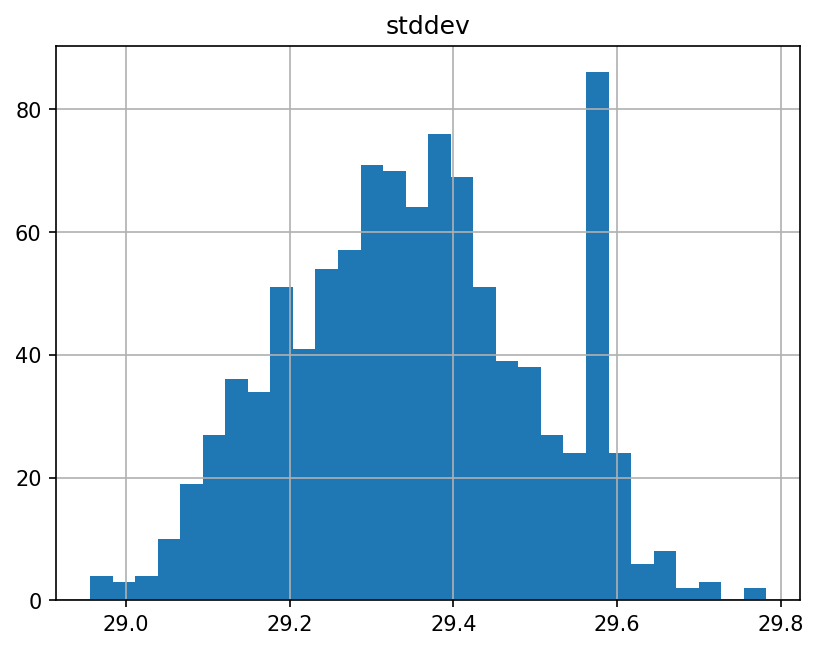

In [20]:
posteriors = ["l_0", "l_x", "l_p", "l_t", "l_tx", "stddev"]
for name in posteriors:
    post = hbr_samples[name]
    plt.figure(dpi=150)
    plt.hist(post, bins=30)
    plt.title(name)
    plt.grid()
    plt.show()

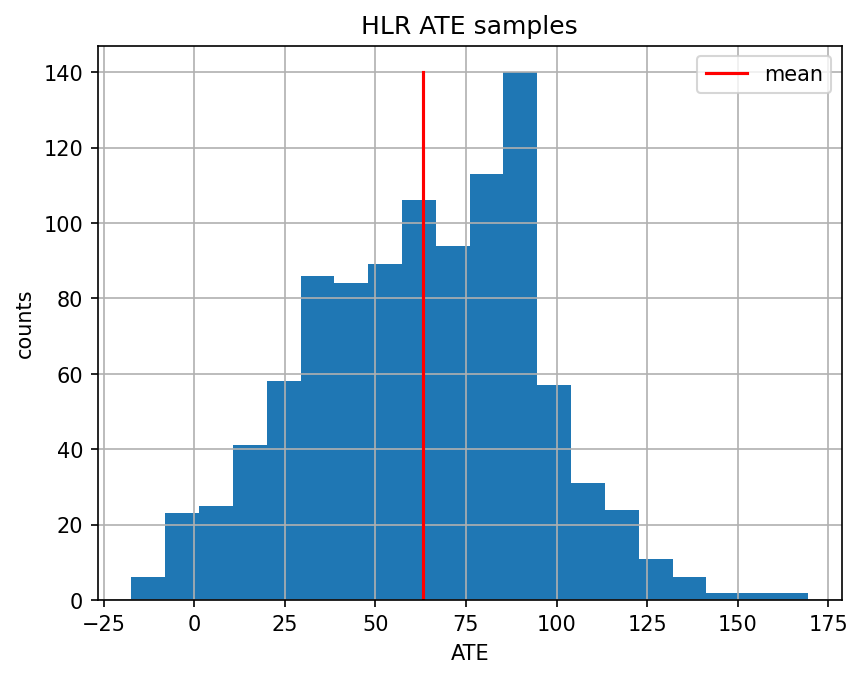

In [21]:
plt.figure(dpi=150)
cnt, *_ = plt.hist(ate_hlr_samples, bins=20)
plt.plot([ate_hlr, ate_hlr], [0, max(cnt)], 'r', label="mean")
plt.title("HLR ATE samples")
plt.xlabel("ATE")
plt.ylabel("counts")
plt.grid()
plt.legend()
plt.show()

## Bayesian Causal Forest

In [22]:
NUM_TREES_PR  = 200
NUM_TREES_TRT = 50

cf = XBCF(
    #model="Normal",
    parallel=True, 
    num_sweeps=2000, 
    burnin=499,
    #max_depth=250,
    num_trees_pr=NUM_TREES_PR,
    num_trees_trt=NUM_TREES_TRT,
    #num_cutpoints=100,
    #Nmin=1,
    #mtry_pr=X1.shape[1], # default 0 seems to be 'all'
    #mtry_trt=X.shape[1], 
    #tau_pr=0.6 * np.var(y)/NUM_TREES_PR, #0.6 * np.var(y) / /NUM_TREES_PR,
    #tau_trt=0.1 * np.var(y)/NUM_TREES_TRT, #0.1 * np.var(y) / /NUM_TREES_TRT,
    alpha_pr=0.95, # shrinkage (splitting probability)
    beta_pr=2, # shrinkage (tree depth)
    alpha_trt=0.25, # shrinkage for treatment part
    beta_trt=3,
    p_categorical_pr=0,
    p_categorical_trt=0,
    standardize_target=True, # standardize y and unstandardize for prediction
)


In [23]:
cf.fit(
    x_t=X, # Covariates treatment effect
    x=X, # Covariates outcome (including propensity score)
    y=y,  # Outcome
    z=t.astype("int32"), # Treatment group
)

XBCF(num_sweeps = 2000, burnin = 499, max_depth = 250, Nmin = 1, num_cutpoints = 100, no_split_penality = 4.605170185988092, mtry_pr = 91, mtry_trt = 91, p_categorical_pr = 0, p_categorical_trt = 0, num_trees_pr = 200, alpha_pr = 0.95, beta_pr = 2.0, tau_pr = 3325.0019999398064, kap_pr = 16.0, s_pr = 4.0, pr_scale = False, num_trees_trt = 50, alpha_trt = 0.25, beta_trt = 3.0, tau_trt = 2216.6679999598714, kap_trt = 16.0, s_trt = 4.0, trt_scale = False, verbose = False, parallel = True, set_random_seed = False, random_seed = 0, sample_weights_flag = True, a_scaling = True, b_scaling = True)

In [24]:
tau_posterior = cf.predict(X, return_mean=False)
ate_cbf_samples = tau_posterior.mean(axis=0)
ate_cbf = ate_cbf_samples.mean()
ci_cbf = mstats.mquantiles(ate_cbf_samples, prob=[0.025, 0.975])

print("Bayesian Causal Forest")
#print(f"  R-squared = {score_samples.mean():.4f} ({score_samples.std():.4f})")
print(f"  ATE: {ate_cbf:.4f}")
print(f"  CI (0.025, 0.975): [{ci_cbf[0]:.4f}, {ci_cbf[1]:.4f}]")

Bayesian Causal Forest
  ATE: 84.5136
  CI (0.025, 0.975): [26.2791, 141.1692]


## Plot ATE

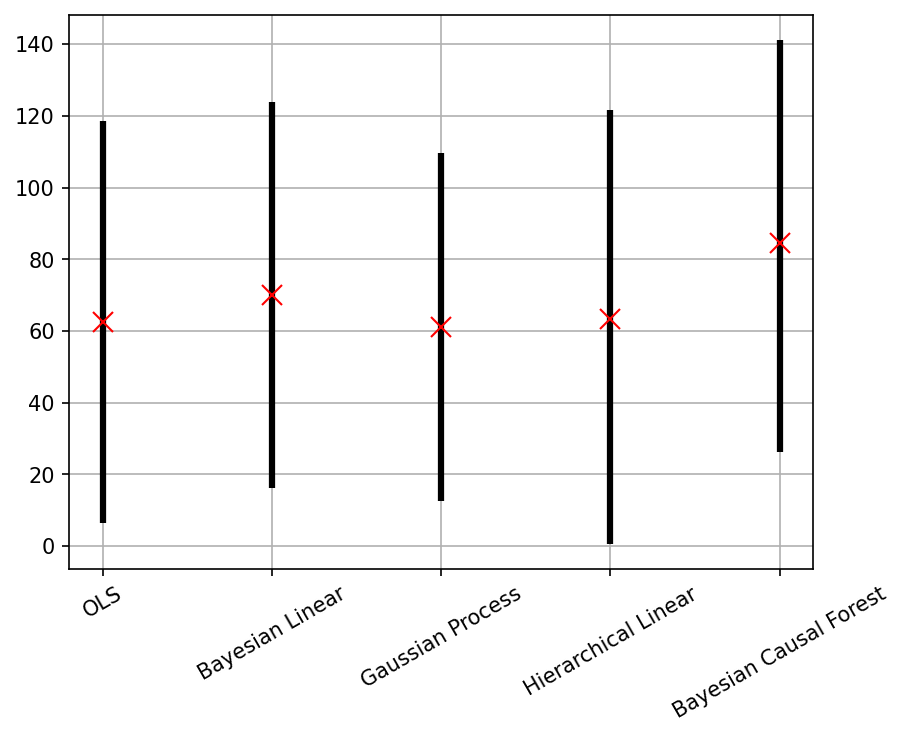

In [26]:
ate_labels = ["OLS", "Bayesian Linear", "Gaussian Process", "Hierarchical Linear", "Bayesian Causal Forest"]
ate = [ate_ols, ate_blr, ate_gp, ate_hlr, ate_cbf]
ci = [ci_ols, ci_blr, ci_gp, ci_hlr, ci_cbf]
ind = np.arange(len(ate))

plt.figure(dpi=150)
plt.vlines(ind, ymin=[c[0] for c in ci], ymax=[c[1] for c in ci], colors='k', linewidth=3)
plt.plot(ind, ate, 'rx', markersize=10)
plt.xticks(ind, labels=ate_labels, rotation=30)
plt.grid()
plt.show()